In [1]:
#.............................................
# IMPORT STATEMENTS
#.............................................

# local env is py310

#General Python math functions
import math
#Loading in data (netcdf files)
import h5py
#Handling data
import numpy as np
import netCDF4 as nc
#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

#machine learning package
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() 
print(tf.__version__)

#Interpreting neural networks 
import  shap


2023-01-11 16:03:55.675300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
2.10.0


/Users/amamalakis/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#.............................................
# LOAD SAI DATA
#.............................................

# load and print netcdf data 

fn = 'surf_temperature/daily/SAI/ts_CESM_WACCM_SAI_2035_2069_r1-10_daily_mean_2pt5degree.nc'
ds = nc.Dataset(fn)

print(ds)

ts_SAI=np.array(ds['TS'][:])-273.15 # K --> C
ts_SAI=ts_SAI.swapaxes(-1, -2)

lat=np.array(ds['lat'][:])
lon=np.array(ds['lon'][:])

del ds, fn

print('SAI DATA HAVE BEEN LOADED')


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Title: CESM2-WACCM, SAI, daily TS, 2035-2069, 10 ensembles, 2.5 by 2.5 degrees
    dimensions(sizes): lat(73), lon(144), time(12775), ensemble(10)
    variables(dimensions): float64 lat(lat), float64 lon(lon), float64 time(time), float64 TS(ensemble, time, lon, lat)
    groups: 
SAI DATA HAVE BEEN LOADED


In [3]:
#.............................................
# LOAD SSP DATA
#.............................................

# load and print netcdf data 

fn = 'surf_temperature/daily/SSP2-4.5/ts_CESM_WACCM_SSP_2015_2069_r1-10_daily_mean_2pt5degree.nc'
ds = nc.Dataset(fn)

print(ds)

ts_SSP=np.array(ds['TS'][:])-273.15 # K --> C
ts_SSP=ts_SSP.swapaxes(-1, -2)

del ds, fn

print('SSP DATA HAVE BEEN LOADED')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Title: CESM2-WACCM, SSP, daily TS, 2015-2069, 10 ensembles, 2.5 by 2.5 degrees
    dimensions(sizes): lat(73), lon(144), time(20075), ensemble(10)
    variables(dimensions): float64 lat(lat), float64 lon(lon), float64 time(time), float64 TS(ensemble, time, lon, lat)
    groups: 
SSP DATA HAVE BEEN LOADED


In [4]:
#.............................................
# GET LAND MASK
#.............................................

# load and print netcdf data 

fn = 'soil_water/SAI/soilwater_CESM_WACCM_SAI_2035_2069_r1-10_monthly_mean_2pt5degree.nc'
ds = nc.Dataset(fn)

print(ds)

landfrac=np.array(ds['LANDFRAC'][:])
landfrac=landfrac.swapaxes(-1, -2)

del ds, fn

print('landfrac DATA HAVE BEEN LOADED')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Title: CESM2-WACCM, SAI, monthly soil water, 2035-2069, 10 ensembles, 2.5 by 2.5 degrees
    dimensions(sizes): lat(73), lon(144), time(420), level(20), ensemble(10)
    variables(dimensions): float64 lat(lat), float64 lon(lon), float64 time(time), float64 SOILW(ensemble, level, time, lon, lat), float64 LANDFRAC(lon, lat)
    groups: 
landfrac DATA HAVE BEEN LOADED


In [5]:
# get series of annual mean, annual-max temp and annual-max 5day temp

n_years_SAI=int((np.shape(ts_SAI)[1])/365)
ts_SAI_ann=ts_SAI[:,0:n_years_SAI,:,:]*0
ts_SAI_ann_max=np.copy(ts_SAI_ann)
ts_SAI_ann_5dmax=np.copy(ts_SAI_ann)
ts_SAI=np.concatenate((ts_SAI,(ts_SAI[:,0:4,:,:]*0-10**10)),axis=1) # this is for the calculation of the annual-max 5day temp

for t in np.arange(0,n_years_SAI,1):
    ts_SAI_ann[:,t,:,:]=np.mean(ts_SAI[:,t*365:(t+1)*365,:,:],axis=1)
    ts_SAI_ann_max[:,t,:,:]=np.max(ts_SAI[:,t*365:(t+1)*365,:,:],axis=1)
    # calculation of the annual-max 5day temp
    bb=np.cumsum(ts_SAI[:,t*365:(t+1)*365+4,:,:],axis=1)
    bb[:,5:,:,:] = bb[:,5:,:,:] - bb[:,:-5,:,:]
    bb=np.delete(bb,np.arange(0,4),1)
    ts_SAI_ann_5dmax[:,t,:,:]=np.max(bb,axis=1)/5
    del bb

n_years_SSP=int((np.shape(ts_SSP)[1])/365)
ts_SSP_ann=ts_SSP[:,0:n_years_SSP,:,:]*0
ts_SSP_ann_max=np.copy(ts_SSP_ann)
ts_SSP_ann_5dmax=np.copy(ts_SSP_ann)
ts_SSP=np.concatenate((ts_SSP,(ts_SSP[:,0:4,:,:]*0-10**10)),axis=1) # this is for the calculation of the annual-max 5day temp

for t in np.arange(0,n_years_SSP,1):
    ts_SSP_ann[:,t,:,:]=np.mean(ts_SSP[:,t*365:(t+1)*365,:,:],axis=1)
    ts_SSP_ann_max[:,t,:,:]=np.max(ts_SSP[:,t*365:(t+1)*365,:,:],axis=1)
    # calculation of the annual-max 5day temp
    bb=np.cumsum(ts_SSP[:,t*365:(t+1)*365+4,:,:],axis=1)
    bb[:,5:,:,:] = bb[:,5:,:,:] - bb[:,:-5,:,:]
    bb=np.delete(bb,np.arange(0,4),1)
    ts_SSP_ann_5dmax[:,t,:,:]=np.max(bb,axis=1)/5
    del bb


del ts_SAI, ts_SSP

In [6]:
#...........................................
# Calculate Global Mean Temp for each year and SAI member
#...........................................

from cmath import nan

cosl=np.cos(np.pi*lat/180) #cos(lat) as a vector 
cosll=np.tile(cosl,(1,1,1,1))
coslat=np.tile(cosll,(10,n_years_SAI,144,1)) #replicate vector
coslat=np.swapaxes(coslat,-1,-2) #matrix of cos(lat)

landfrac_matrix=np.tile(landfrac,(1,1,1,1))
landfrac_matrix=np.tile(landfrac_matrix,(10,n_years_SAI,1,1)) #matrix of land fraction

#mean
GMT_sai=np.sum(np.multiply(ts_SAI_ann,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))
GMT_land_sai=np.sum(np.multiply(np.multiply(ts_SAI_ann,landfrac_matrix),coslat),axis=(2,3))/np.sum(np.multiply(coslat,landfrac_matrix),axis=(2,3))
#max
GMTmax_sai=np.sum(np.multiply(ts_SAI_ann_max,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))
GMTmax_land_sai=np.sum(np.multiply(np.multiply(ts_SAI_ann_max,landfrac_matrix),coslat),axis=(2,3))/np.sum(np.multiply(coslat,landfrac_matrix),axis=(2,3))
#5day max
GMT5dmax_sai=np.sum(np.multiply(ts_SAI_ann_5dmax,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))
GMT5dmax_land_sai=np.sum(np.multiply(np.multiply(ts_SAI_ann_5dmax,landfrac_matrix),coslat),axis=(2,3))/np.sum(np.multiply(coslat,landfrac_matrix),axis=(2,3))

# also get series over land 
ts_land_SAI_ann=np.copy(ts_SAI_ann)
ts_land_SAI_ann[landfrac_matrix==0]=nan
ts_land_SAI_ann_max=np.copy(ts_SAI_ann_max)
ts_land_SAI_ann_max[landfrac_matrix==0]=nan
ts_land_SAI_ann_5dmax=np.copy(ts_SAI_ann_5dmax)
ts_land_SAI_ann_5dmax[landfrac_matrix==0]=nan

In [7]:
#...........................................
# Calculate Global Mean Temp for each year and SSP member
#...........................................

cosl=np.cos(np.pi*lat/180) #cos(lat) as a vector 
cosll=np.tile(cosl,(1,1,1,1))
coslat=np.tile(cosll,(10,n_years_SSP,144,1)) #replicate vector
coslat=np.swapaxes(coslat,-1,-2) #matrix of cos(lat)

landfrac_matrix=np.tile(landfrac,(1,1,1,1))
landfrac_matrix=np.tile(landfrac_matrix,(10,n_years_SSP,1,1)) #matrix of land fraction

#mean
GMT_ssp=np.sum(np.multiply(ts_SSP_ann,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))
GMT_land_ssp=np.sum(np.multiply(np.multiply(ts_SSP_ann,landfrac_matrix),coslat),axis=(2,3))/np.sum(np.multiply(coslat,landfrac_matrix),axis=(2,3))
#max
GMTmax_ssp=np.sum(np.multiply(ts_SSP_ann_max,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))
GMTmax_land_ssp=np.sum(np.multiply(np.multiply(ts_SSP_ann_max,landfrac_matrix),coslat),axis=(2,3))/np.sum(np.multiply(coslat,landfrac_matrix),axis=(2,3))
#5day max
GMT5dmax_ssp=np.sum(np.multiply(ts_SSP_ann_5dmax,coslat),axis=(2,3))/np.sum(coslat,axis=(2,3))
GMT5dmax_land_ssp=np.sum(np.multiply(np.multiply(ts_SSP_ann_5dmax,landfrac_matrix),coslat),axis=(2,3))/np.sum(np.multiply(coslat,landfrac_matrix),axis=(2,3))

# also get series over land 
ts_land_SSP_ann=np.copy(ts_SSP_ann)
ts_land_SSP_ann[landfrac_matrix==0]=nan
ts_land_SSP_ann_max=np.copy(ts_SSP_ann_max)
ts_land_SSP_ann_max[landfrac_matrix==0]=nan
ts_land_SSP_ann_5dmax=np.copy(ts_SSP_ann_5dmax)
ts_land_SSP_ann_5dmax[landfrac_matrix==0]=nan


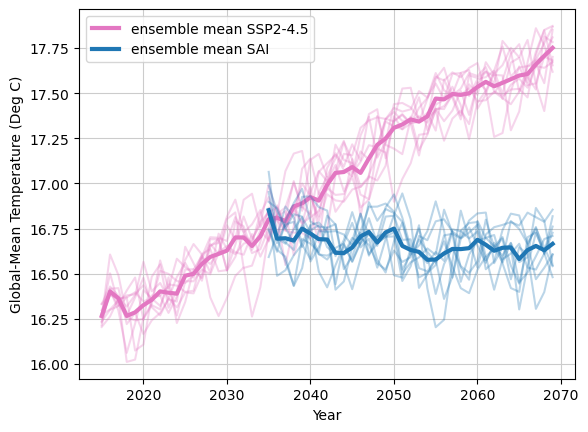

In [8]:
# plot global mean temp series

for i in np.arange(0,10,1):
 plt.plot(np.arange(2015,2070), GMT_ssp[i,:],'C6',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(GMT_ssp,axis=0),'C6',label='ensemble mean SSP2-4.5', linewidth=3)

for i in np.arange(0,10,1):
 plt.plot(np.arange(2035,2070), GMT_sai[i,:],'C0',alpha=0.3)
plt.plot(np.arange(2035,2070), np.mean(GMT_sai,axis=0),'C0',label='ensemble mean SAI', linewidth=3)

plt.xlabel('Year')
plt.ylabel('Global-Mean Temperature (Deg C)')
plt.axis('tight')
plt.grid(color='0.8')
plt.legend()
plt.show()

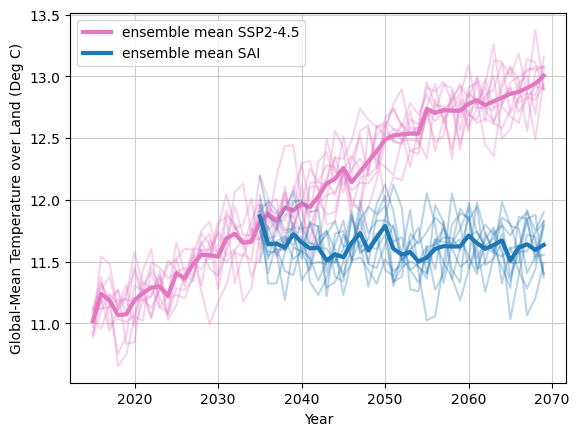

In [9]:
# plot global mean temp series over land

for i in np.arange(0,10,1):
 plt.plot(np.arange(2015,2070), GMT_land_ssp[i,:],'C6',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(GMT_land_ssp,axis=0),'C6',label='ensemble mean SSP2-4.5', linewidth=3)

for i in np.arange(0,10,1):
 plt.plot(np.arange(2035,2070), GMT_land_sai[i,:],'C0',alpha=0.3)
plt.plot(np.arange(2035,2070), np.mean(GMT_land_sai,axis=0),'C0',label='ensemble mean SAI', linewidth=3)

plt.xlabel('Year')
plt.ylabel('Global-Mean Temperature over Land (Deg C)')
plt.axis('tight')
plt.grid(color='0.8')
plt.legend()
plt.show()

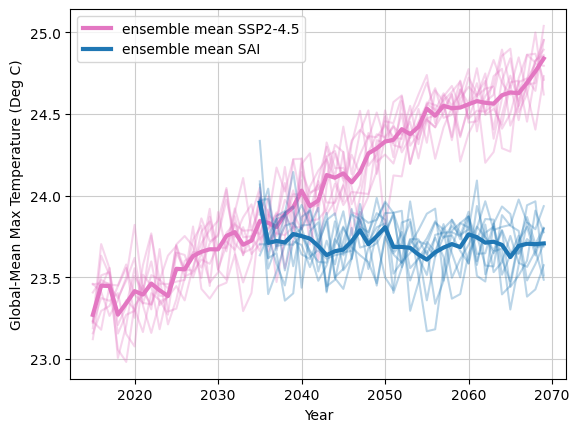

In [10]:
# plot global mean of annual max temp series

for i in np.arange(0,10,1):
 plt.plot(np.arange(2015,2070), GMTmax_ssp[i,:],'C6',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(GMTmax_ssp,axis=0),'C6',label='ensemble mean SSP2-4.5', linewidth=3)

for i in np.arange(0,10,1):
 plt.plot(np.arange(2035,2070), GMTmax_sai[i,:],'C0',alpha=0.3)
plt.plot(np.arange(2035,2070), np.mean(GMTmax_sai,axis=0),'C0',label='ensemble mean SAI', linewidth=3)

plt.xlabel('Year')
plt.ylabel('Global-Mean Max Temperature (Deg C)')
plt.axis('tight')
plt.grid(color='0.8')
plt.legend()
plt.show()

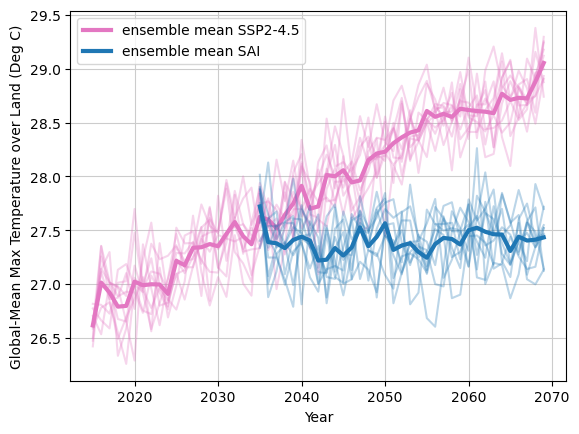

In [11]:
# plot global mean of annual max temp series over land

for i in np.arange(0,10,1):
 plt.plot(np.arange(2015,2070), GMTmax_land_ssp[i,:],'C6',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(GMTmax_land_ssp,axis=0),'C6',label='ensemble mean SSP2-4.5', linewidth=3)

for i in np.arange(0,10,1):
 plt.plot(np.arange(2035,2070), GMTmax_land_sai[i,:],'C0',alpha=0.3)
plt.plot(np.arange(2035,2070), np.mean(GMTmax_land_sai,axis=0),'C0',label='ensemble mean SAI', linewidth=3)

plt.xlabel('Year')
plt.ylabel('Global-Mean Max Temperature over Land (Deg C)')
plt.axis('tight')
plt.grid(color='0.8')
plt.legend()
plt.show()

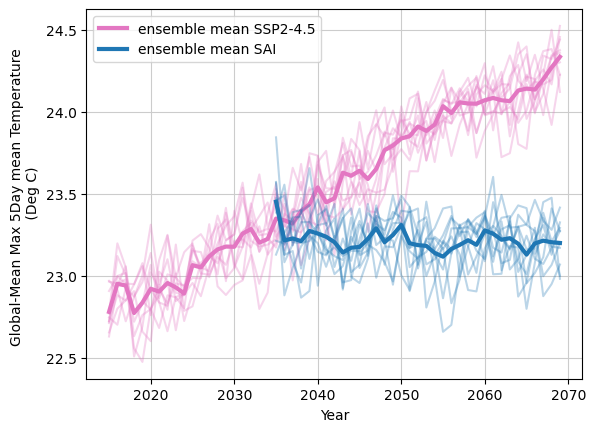

In [12]:
# plot global mean of annual 5d-max temp series

for i in np.arange(0,10,1):
 plt.plot(np.arange(2015,2070), GMT5dmax_ssp[i,:],'C6',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(GMT5dmax_ssp,axis=0),'C6',label='ensemble mean SSP2-4.5', linewidth=3)

for i in np.arange(0,10,1):
 plt.plot(np.arange(2035,2070), GMT5dmax_sai[i,:],'C0',alpha=0.3)
plt.plot(np.arange(2035,2070), np.mean(GMT5dmax_sai,axis=0),'C0',label='ensemble mean SAI', linewidth=3)

plt.xlabel('Year')
plt.ylabel('Global-Mean Max 5Day mean Temperature \n (Deg C)')
plt.axis('tight')
plt.grid(color='0.8')
plt.legend()
plt.show()

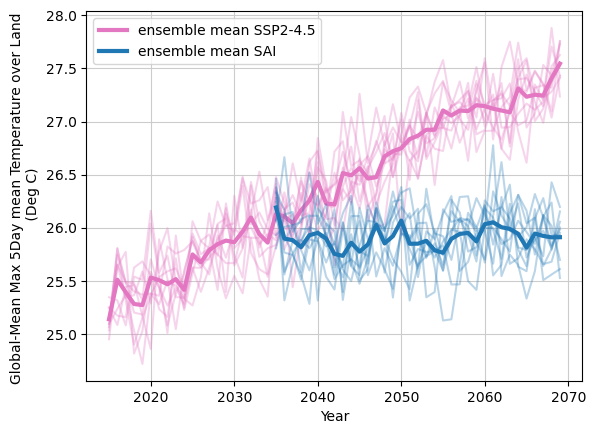

In [13]:
# plot global mean of annual 5d-max temp series over land

for i in np.arange(0,10,1):
 plt.plot(np.arange(2015,2070), GMT5dmax_land_ssp[i,:],'C6',alpha=0.3)
plt.plot(np.arange(2015,2070), np.mean(GMT5dmax_land_ssp,axis=0),'C6',label='ensemble mean SSP2-4.5', linewidth=3)

for i in np.arange(0,10,1):
 plt.plot(np.arange(2035,2070), GMT5dmax_land_sai[i,:],'C0',alpha=0.3)
plt.plot(np.arange(2035,2070), np.mean(GMT5dmax_land_sai,axis=0),'C0',label='ensemble mean SAI', linewidth=3)

plt.xlabel('Year')
plt.ylabel('Global-Mean Max 5Day mean Temperature over Land \n (Deg C)')
plt.axis('tight')
plt.grid(color='0.8')
plt.legend()
plt.show()

In [14]:
from cmath import sqrt
import scipy.stats


def significant_changes_tstat(z1,z2,lat,lon,filter,p_sgn=0.01):
    
    LAT=np.swapaxes(np.tile(np.tile(lat,(1,1)),(lon.shape[0],1)),0,1)
    LON=np.tile(np.tile(lon,(1,1)),(lat.shape[0],1))

    z1=z1.reshape(z1.shape[0]*z1.shape[1],z1.shape[2],z1.shape[3])
    z2=z2.reshape(z2.shape[0]*z2.shape[1],z2.shape[2],z2.shape[3])

    df=(((np.var(z1,axis=0)/z1.shape[0])+(np.var(z2,axis=0)/z2.shape[0]))**2)/(((np.var(z1,axis=0)/z1.shape[0])**2)/(z1.shape[0]-1)+((np.var(z2,axis=0)/z2.shape[0])**2)/(z2.shape[0]-1))
    t_cr=scipy.stats.t.ppf((1-p_sgn/2)*np.ones((df.shape)),df)

    t_stat=(np.mean(z1,axis=0)-np.mean(z2,axis=0))/((np.var(z1,axis=0)/z1.shape[0])+(np.var(z2,axis=0)/z2.shape[0])**(1/2))
    
    LAT[np.isnan(t_stat)]=nan
    LON[np.isnan(t_stat)]=nan
    LAT[np.abs(t_stat)<=t_cr]=nan
    LON[np.abs(t_stat)<=t_cr]=nan
    LAT[filter==0]=nan
    LON[filter==0]=nan

    LAT=LAT.reshape(LAT.shape[0]*LAT.shape[1])
    LON=LON.reshape(LON.shape[0]*LON.shape[1])

    LAT=np.delete(LAT,LAT==nan,0)
    LON=np.delete(LON,LON==nan,0)

    return LAT, LON


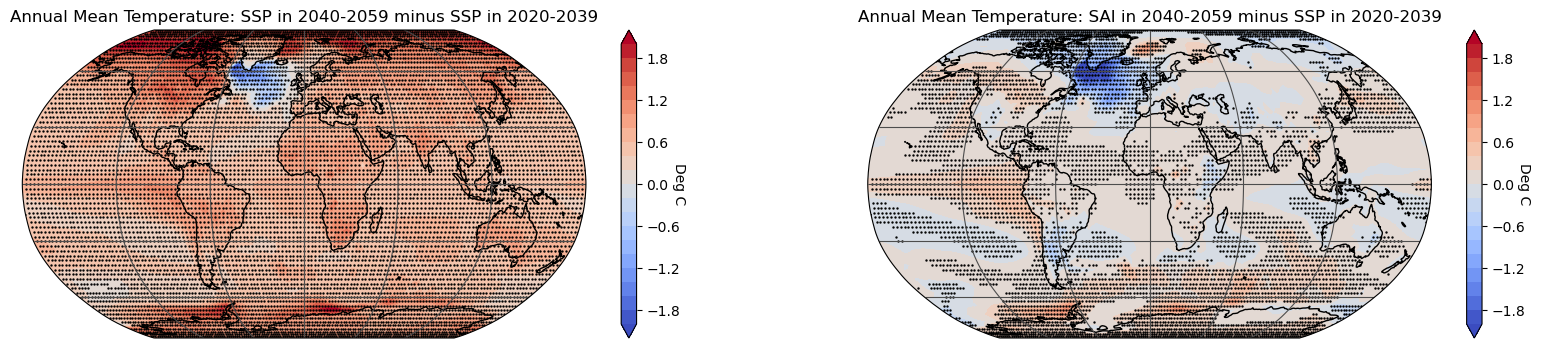

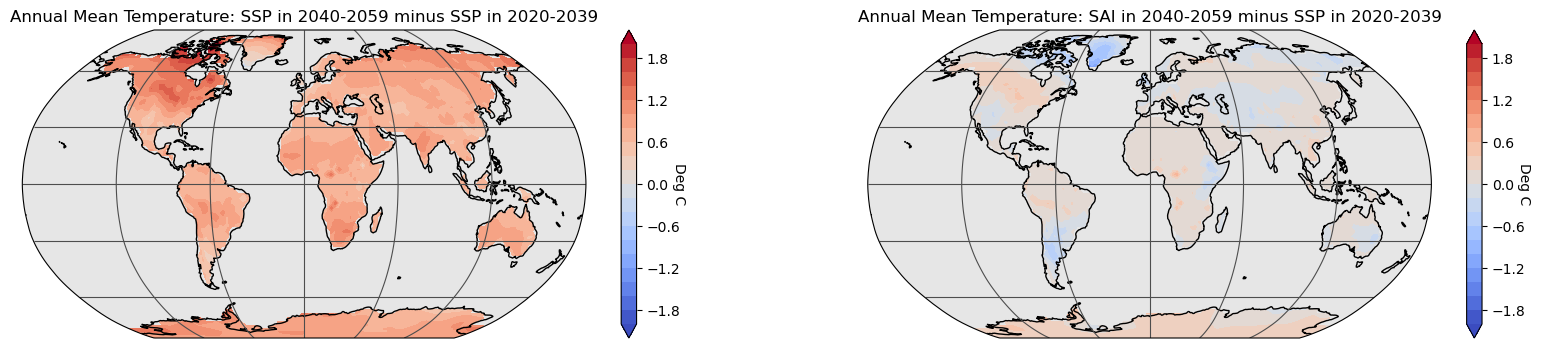

In [15]:
#PLOTTING SPATIAL PATTERNS OF CHANGE IN TEMP

plt.figure(figsize=(20,4))   
ax=plt.subplot(1,2,1,projection=ccrs.Robinson())
plt.gca().set_facecolor('0.9')
samplep,lonp = add_cyclic_point(np.mean(ts_SSP_ann[:,25:45,:,:], axis=(0,1))-np.mean(ts_SSP_ann[:,5:25,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="coolwarm",levels = np.linspace(-2,2,21),extend = 'both')
lat_sgn, lon_sgn = significant_changes_tstat(ts_SSP_ann[:,25:45,:,:],ts_SSP_ann[:,5:25,:,:],lat,lon,np.isnan(ts_SSP_ann[0,0,:,:])==0,0.01)
ax.scatter(lon_sgn,lat_sgn,2,'k','.',transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)   
cbar.set_label('Deg C', rotation=270)
plt.title('Annual Mean Temperature: SSP in 2040-2059 minus SSP in 2020-2039' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines(color='0.3')
ax.set_global() 
#plt.legend()
ax=plt.subplot(1,2,2,projection=ccrs.Robinson())
plt.gca().set_facecolor('0.9')
samplep,lonp = add_cyclic_point(np.mean(ts_SAI_ann[:,5:25,:,:], axis=(0,1))-np.mean(ts_SSP_ann[:,5:25,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="coolwarm",levels = np.linspace(-2,2,21),extend = 'both')
lat_sgn, lon_sgn = significant_changes_tstat(ts_SAI_ann[:,5:25,:,:],ts_SSP_ann[:,5:25,:,:],lat,lon,np.isnan(ts_SSP_ann[0,0,:,:])==0,0.01)
ax.scatter(lon_sgn,lat_sgn,2,'k','.',transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)  
cbar.set_label('Deg C', rotation=270) 
plt.title('Annual Mean Temperature: SAI in 2040-2059 minus SSP in 2020-2039' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines(color='0.3')
ax.set_global() 
#plt.legend()
plt.show()

plt.figure(figsize=(20,4))   
ax=plt.subplot(1,2,1,projection=ccrs.Robinson())
plt.gca().set_facecolor('0.9')
samplep,lonp = add_cyclic_point(np.mean(ts_land_SSP_ann[:,25:45,:,:], axis=(0,1))-np.mean(ts_land_SSP_ann[:,5:25,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="coolwarm",levels = np.linspace(-2,2,21),extend = 'both')
lat_sgn, lon_sgn = significant_changes_tstat(ts_land_SSP_ann[:,25:45,:,:],ts_land_SSP_ann[:,5:25,:,:],lat,lon,np.isnan(ts_land_SSP_ann[0,0,:,:])==0,0.01)
#ax.scatter(lon_sgn,lat_sgn,2,'k','.',transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)   
cbar.set_label('Deg C', rotation=270)
plt.title('Annual Mean Temperature: SSP in 2040-2059 minus SSP in 2020-2039' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines(color='0.3')
ax.set_global() 
#plt.legend()
ax=plt.subplot(1,2,2,projection=ccrs.Robinson())
plt.gca().set_facecolor('0.9')
samplep,lonp = add_cyclic_point(np.mean(ts_land_SAI_ann[:,5:25,:,:], axis=(0,1))-np.mean(ts_land_SSP_ann[:,5:25,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="coolwarm",levels = np.linspace(-2,2,21),extend = 'both')
lat_sgn, lon_sgn = significant_changes_tstat(ts_land_SAI_ann[:,5:25,:,:],ts_land_SSP_ann[:,5:25,:,:],lat,lon,np.isnan(ts_land_SSP_ann[0,0,:,:])==0,0.01)
#ax.scatter(lon_sgn,lat_sgn,2,'k','.',transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)  
cbar.set_label('Deg C', rotation=270) 
plt.title('Annual Mean Temperature: SAI in 2040-2059 minus SSP in 2020-2039' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines(color='0.3')
ax.set_global() 
#plt.legend()
plt.show()

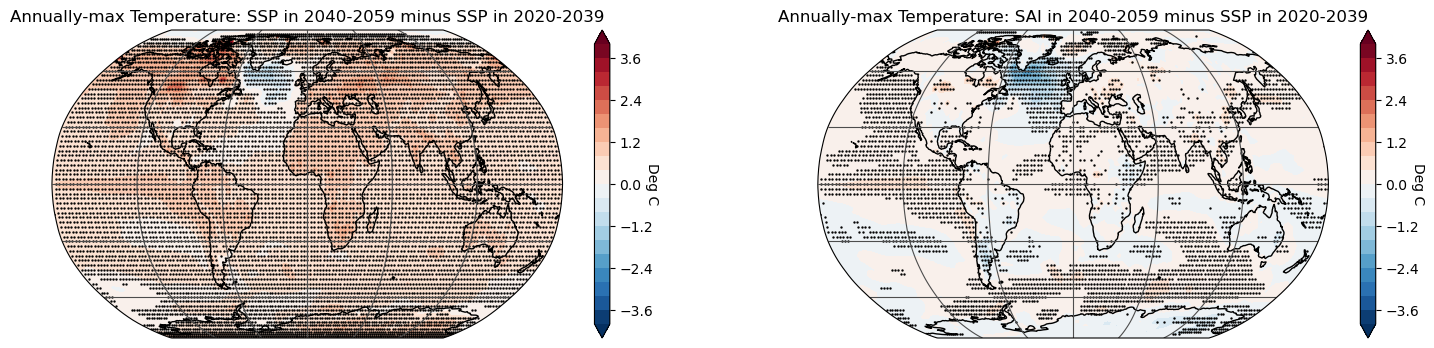

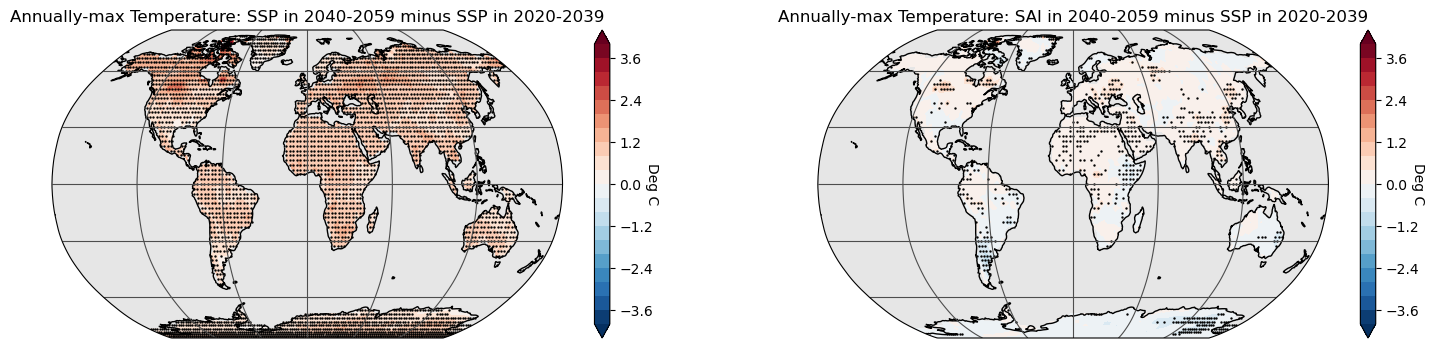

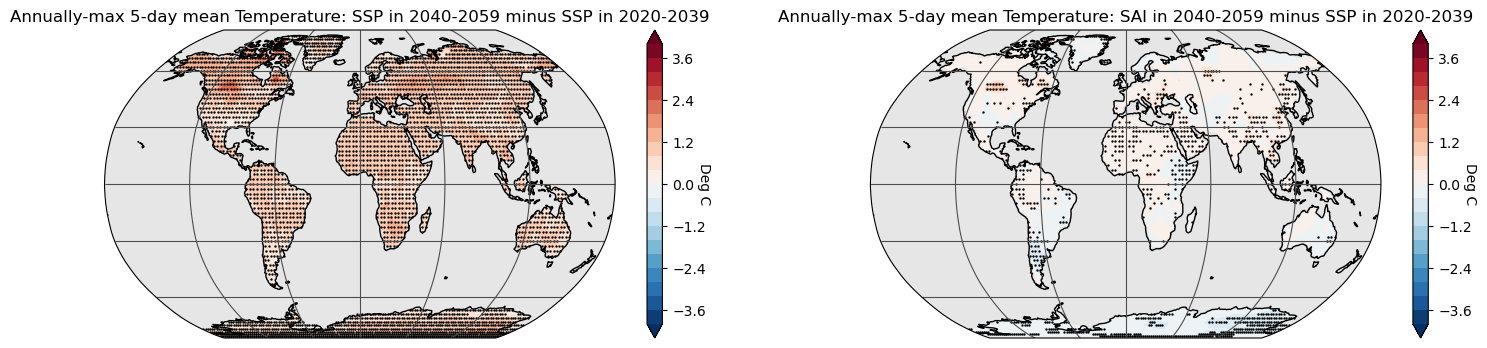

In [16]:
#PLOTTING SPATIAL PATTERNS OF CHANGE IN MAX TEMP

plt.figure(figsize=(28,4))   
ax=plt.subplot(1,3,1,projection=ccrs.Robinson())
plt.gca().set_facecolor('0.9')
samplep,lonp = add_cyclic_point(np.mean(ts_SSP_ann_max[:,25:45,:,:], axis=(0,1))-np.mean(ts_SSP_ann_max[:,5:25,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="RdBu_r",levels = np.linspace(-4,4,21),extend = 'both')
lat_sgn, lon_sgn = significant_changes_tstat(ts_SSP_ann_max[:,25:45,:,:],ts_SSP_ann_max[:,5:25,:,:],lat,lon,np.isnan(ts_SSP_ann_max[0,0,:,:])==0,0.01)
ax.scatter(lon_sgn,lat_sgn,2,'k','.',transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)   
cbar.set_label('Deg C', rotation=270)
plt.title('Annually-max Temperature: SSP in 2040-2059 minus SSP in 2020-2039' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines(color='0.3')
ax.set_global() 
#plt.legend()
ax=plt.subplot(1,3,2,projection=ccrs.Robinson())
plt.gca().set_facecolor('0.9')
samplep,lonp = add_cyclic_point(np.mean(ts_SAI_ann_max[:,5:25,:,:], axis=(0,1))-np.mean(ts_SSP_ann_max[:,5:25,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="RdBu_r",levels = np.linspace(-4,4,21),extend = 'both')
lat_sgn, lon_sgn = significant_changes_tstat(ts_SAI_ann_max[:,5:25,:,:],ts_SSP_ann_max[:,5:25,:,:],lat,lon,np.isnan(ts_SSP_ann_max[0,0,:,:])==0,0.01)
ax.scatter(lon_sgn,lat_sgn,2,'k','.',transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)   
cbar.set_label('Deg C', rotation=270)
plt.title('Annually-max Temperature: SAI in 2040-2059 minus SSP in 2020-2039' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines(color='0.3')
ax.set_global() 
#plt.legend()
plt.show()

plt.figure(figsize=(28,4))   
ax=plt.subplot(1,3,1,projection=ccrs.Robinson())
plt.gca().set_facecolor('0.9')
samplep,lonp = add_cyclic_point(np.mean(ts_land_SSP_ann_max[:,25:45,:,:], axis=(0,1))-np.mean(ts_land_SSP_ann_max[:,5:25,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="RdBu_r",levels = np.linspace(-4,4,21),extend = 'both')
lat_sgn, lon_sgn = significant_changes_tstat(ts_land_SSP_ann_max[:,25:45,:,:],ts_land_SSP_ann_max[:,5:25,:,:],lat,lon,np.isnan(ts_land_SSP_ann_max[0,0,:,:])==0,0.01)
ax.scatter(lon_sgn,lat_sgn,2,'k','.',transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)   
cbar.set_label('Deg C', rotation=270)
plt.title('Annually-max Temperature: SSP in 2040-2059 minus SSP in 2020-2039' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines(color='0.3')
ax.set_global() 
#plt.legend()
ax=plt.subplot(1,3,2,projection=ccrs.Robinson())
plt.gca().set_facecolor('0.9')
samplep,lonp = add_cyclic_point(np.mean(ts_land_SAI_ann_max[:,5:25,:,:], axis=(0,1))-np.mean(ts_land_SSP_ann_max[:,5:25,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="RdBu_r",levels = np.linspace(-4,4,21),extend = 'both')
lat_sgn, lon_sgn = significant_changes_tstat(ts_land_SAI_ann_max[:,5:25,:,:],ts_land_SSP_ann_max[:,5:25,:,:],lat,lon,np.isnan(ts_land_SSP_ann_max[0,0,:,:])==0,0.01)
ax.scatter(lon_sgn,lat_sgn,2,'k','.',transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)   
cbar.set_label('Deg C', rotation=270)
plt.title('Annually-max Temperature: SAI in 2040-2059 minus SSP in 2020-2039' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines(color='0.3')
ax.set_global() 
#plt.legend()
plt.show()

plt.figure(figsize=(28,4))   
ax=plt.subplot(1,3,1,projection=ccrs.Robinson())
plt.gca().set_facecolor('0.9')
samplep,lonp = add_cyclic_point(np.mean(ts_land_SSP_ann_5dmax[:,25:45,:,:], axis=(0,1))-np.mean(ts_land_SSP_ann_5dmax[:,5:25,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="RdBu_r",levels = np.linspace(-4,4,21),extend = 'both')
lat_sgn, lon_sgn = significant_changes_tstat(ts_land_SSP_ann_5dmax[:,25:45,:,:],ts_land_SSP_ann_5dmax[:,5:25,:,:],lat,lon,np.isnan(ts_land_SSP_ann_5dmax[0,0,:,:])==0,0.01)
ax.scatter(lon_sgn,lat_sgn,2,'k','.',transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)   
cbar.set_label('Deg C', rotation=270)
plt.title('Annually-max 5-day mean Temperature: SSP in 2040-2059 minus SSP in 2020-2039' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines(color='0.3')
ax.set_global() 
#plt.legend()
ax=plt.subplot(1,3,2,projection=ccrs.Robinson())
plt.gca().set_facecolor('0.9')
samplep,lonp = add_cyclic_point(np.mean(ts_land_SAI_ann_5dmax[:,5:25,:,:], axis=(0,1))-np.mean(ts_land_SSP_ann_5dmax[:,5:25,:,:], axis=(0,1)), coord=lon)
cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="RdBu_r",levels = np.linspace(-4,4,21),extend = 'both')
lat_sgn, lon_sgn = significant_changes_tstat(ts_land_SAI_ann_5dmax[:,5:25,:,:],ts_land_SSP_ann_5dmax[:,5:25,:,:],lat,lon,np.isnan(ts_land_SSP_ann_5dmax[0,0,:,:])==0,0.01)
ax.scatter(lon_sgn,lat_sgn,2,'k','.',transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)   
cbar.set_label('Deg C', rotation=270)
plt.title('Annually-max 5-day mean Temperature: SAI in 2040-2059 minus SSP in 2020-2039' ) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('tight')
ax.coastlines()
ax.gridlines(color='0.3')
ax.set_global() 
#plt.legend()
plt.show()

In [17]:
#.............................................
# NEURAL NETWORK FIT
#.............................................

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dropout, Dense

def NN_fit(x_train,x_val,y_train,y_val,SEED=8889, DROP_RATE=0.3, HIDDENS=[5,5,5], ACTIVATIONS=['relu','relu','relu'] , RIDGE=[0., 0., 0.], LEARNING_RATE=0.001,BATCH_SIZE=32,NUM_EPOCHS=10000,PATIENCE=30,VERBOSITY=0):

  tf.keras.backend.clear_session()            
  tf.random.set_seed(SEED)
  np.random.seed(SEED) 

  # Constructing the model
  inputs=Input(shape=x_train.shape[1:]) 
  layers=Dropout(DROP_RATE,seed=SEED) (inputs)
  
  for hidden, activation, ridge in zip(HIDDENS, ACTIVATIONS, RIDGE):
         layers = Dense(hidden, activation=activation,
         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00, l2=ridge),
         bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
         kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)

  output_layer=Dense(1, activation='sigmoid', use_bias=True, 
            bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)  

  model = Model(inputs, output_layer)
  #We will use the stochastic gradient descent (adam) optimizer
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss = 'binary_crossentropy', #Our loss function is based on categorical cross entropy
              metrics=['accuracy'], #We will print out the accuracy as the network is trained
              )

  # define early stopping callback
  EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=PATIENCE,
                                                   verbose=VERBOSITY,
                                                   mode='auto',
                                                   restore_best_weights=True)
              
  history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
          batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, shuffle=True, verbose=0,callbacks=[EARLY_STOPPING])
          
  return model, history
    

In [34]:
#.............................................
# TRAINING LOOP AND PLOT FUNCTION
#.............................................

from tabnanny import verbose


def train_loop(field,file_name):


 nonan_v=field[0,0,:,:].reshape(field.shape[2]*field.shape[3])
 nonan_v=np.abs(np.isnan(nonan_v)-1) # grids where there is no field records

 set=np.arange(0,10)

 # create lists for looping
 predictions=[]
 model_attributions=[]
 model_hparameters=[]
 
 plt.figure(figsize=(28,4)) 

 for m in np.arange(0,10,1):
 
     # build the training set
     train_set=np.delete(set,[m,m-1])

     # standardize
     X_train=(field[train_set,0:40,:,:]-np.mean(field[train_set,15:25,:,:], axis=(0,1)))/np.std(field[train_set,0:40,:,:], axis=(0,1)) # train members
     X_val=(field[m-1,0:40,:,:]-np.mean(field[train_set,15:25,:,:], axis=(0,1)))/np.std(field[train_set,0:40,:,:], axis=(0,1))   # val member
     X_test=(field[m,:,:,:]-np.mean(field[train_set,15:25,:,:], axis=(0,1)))/np.std(field[train_set,0:40,:,:], axis=(0,1))   # test member
     
     year=np.arange(2020,2060)
     Y_val=np.copy(year)
     Y_val[Y_val<2040]=0
     Y_val[Y_val>2039]=1
     Y_train=np.tile(Y_val,(8))

 
     # reshaping
     X_train=X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2]*X_train.shape[3])
     X_val=X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2])
     X_test=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
     # keep only land grids
     X_train=np.delete(X_train,nonan_v==0,1)
     X_val=np.delete(X_val,nonan_v==0,1) 
     X_test=np.delete(X_test,nonan_v==0,1) 
     
     # zero out values that became nan/Inf after standardization
     X_train[np.isnan(X_train)]=0
     X_val[np.isnan(X_val)]=0
     X_test[np.isnan(X_test)]=0
     X_train[np.isinf(X_train)]=0
     X_val[np.isinf(X_val)]=0
     X_test[np.isinf(X_test)]=0

     # fit network loop
     val_loss=10**100 # inital loss
     lr_opt=0
     dropout_opt=0
     num_hid_opt=0
     num_neu_opt=0
     for lr in [0.00001, 0.0001, 0.001, 0.01]: 
         for drop_out in [.1, 0.25, 0.5, 0.75]:  
             for num_hidden in [0, 1, 2, 4]: 
                if num_hidden==0: #logistic regression
                    model_temp,history_temp =NN_fit(X_train,X_val,Y_train,Y_val,DROP_RATE=drop_out, HIDDENS=[],LEARNING_RATE=lr,NUM_EPOCHS=50,PATIENCE=5)
                    loss,acc = model_temp.evaluate(X_val, Y_val,verbose=0)
                    if loss<val_loss:
                       val_loss=loss
                       lr_opt=lr
                       dropout_opt=drop_out
                       num_hid_opt=num_hidden
                       num_neu_opt=0
                else:
                    for num_neurons in [3, 5, 10, 25]:
                        model_temp,history_temp =NN_fit(X_train,X_val,Y_train,Y_val,DROP_RATE=drop_out, HIDDENS=[num_neurons]*num_hidden,RIDGE=[0]*num_hidden,ACTIVATIONS=["relu"]*num_hidden,LEARNING_RATE=lr,NUM_EPOCHS=50,PATIENCE=5)
                        loss,acc = model_temp.evaluate(X_val, Y_val,verbose=0)
                        if loss<val_loss:
                           val_loss=loss
                           lr_opt=lr
                           dropout_opt=drop_out
                           num_hid_opt=num_hidden
                           num_neu_opt=num_neurons                                 
      

     global model
     model,history =NN_fit(X_train,X_val,Y_train,Y_val,DROP_RATE=dropout_opt,HIDDENS=[num_neu_opt]*num_hid_opt,RIDGE=[0]*num_hid_opt,ACTIVATIONS=["relu"]*num_hid_opt,LEARNING_RATE=lr_opt,VERBOSITY=1)
    
     # keep a list of model attributions
     e = shap.DeepExplainer(model, X_test[15:25,:])
     model_attributions.append(np.mean(np.array(e.shap_values(X_test[40:50,:]))[0,:,:],axis=0))
     # Make the test prediction from the model 
     predictions.append(model.predict(X_test))
     # save optimal hyper parameters 
     model_hparameters.append([lr_opt,dropout_opt,num_hid_opt,num_neu_opt])
     
     # plot training history
     plt.subplot(1,4,1)
     plt.plot(history.history['loss'],'C6',alpha=0.5,label='training set')
     plt.plot(history.history['val_loss'],'C7',alpha=0.5,label='validation set')
     plt.title('Loss' ) 
     plt.xlabel('Epoch')
     plt.ylabel('Binary Crossentropy')
     plt.grid(color='0.8')  
     plt.subplot(1,4,2)
     plt.plot(history.history['acc'],'C6',alpha=0.5,label='training set')
     plt.plot(history.history['val_acc'],'C7',alpha=0.5,label='validation set')
     plt.title('Accuracy' ) 
     plt.xlabel('Epoch')
     plt.ylabel('Accuracy')
     plt.grid(color='0.8')   
     ax=plt.subplot(1,4,3)
     plt.plot(lr_opt,dropout_opt,'C6o')
     ax.set_xscale('log')
     plt.title('HyperParameters' ) 
     plt.xlabel('Optimal learning rate')
     plt.ylabel('Optimal droupout rate')
     plt.grid(color='0.8')  
     ax=plt.subplot(1,4,4)
     plt.plot(num_neu_opt,num_hid_opt,'C6o')
     ax.set_xscale('log')
     plt.title('HyperParameters' ) 
     plt.xlabel('Optimal number of neurons per layer')
     plt.ylabel('Optimal number of hidden layers')
     plt.grid(color='0.8')  
 plt.show()

 
 # Plot model weights (average across all training combos)
 model_attributions = np.array(model_attributions)
 model_w = np.zeros((field.shape[0],field.shape[2]*field.shape[3]))*nan
 model_w[:,nonan_v==1]=model_attributions
 model_w=model_w[...,np.newaxis].reshape((field.shape[0],field.shape[2],field.shape[3]))
 plt.figure(figsize=(9,4))   
 ax=plt.axes(projection=ccrs.Robinson())
 plt.gca().set_facecolor('0.9')
 samplep,lonp = add_cyclic_point(np.mean(model_w, axis=0), coord=lon)
 cs = plt.contourf(lonp, lat, samplep, transform=ccrs.PlateCarree(), cmap ="PiYG",levels = np.linspace(-0.001,0.001,21),extend = 'both')
 cbar = plt.colorbar(cs)   
 plt.title('Attributions based on Deep SHAP' ) 
 plt.xlabel('Longitude')
 plt.ylabel('Latitude')
 plt.axis('tight')
 ax.coastlines()
 ax.gridlines(color='0.3')
 ax.set_global() 
 #plt.legend()
 plt.show()

 # plot test predictions
 predictions = np.array(predictions)[:,:,0]
 plt.plot(np.arange(2020,2070), 0.5*np.ones(predictions.shape[1]),'k-',alpha=0.5)
 plt.plot(2040*np.ones(11), np.arange(0,1.1,0.1),'k-',alpha=0.5)
 plt.plot(2060*np.ones(11), np.arange(0,1.1,0.1),'k--',alpha=0.3)
 plt.plot(np.tile(np.tile(np.arange(2020,2070),(1,1)),(10,1)), predictions,'C6.',alpha=0.3)
 plt.plot(np.arange(2020,2070), np.mean(predictions,axis=0),'C6o')
 #plt.errorbar(np.arange(2020,2070), np.mean(predictions,axis=0), yerr=np.std(predictions,axis=0).flatten(), fmt="o")
 plt.xlabel('Actual Year')
 plt.ylabel('Probability the map belongs to post-2040')
 plt.title('Pre/Post-2040 era classification') 
 plt.axis('tight')
 plt.ylim(0, 1)
 #plt.legend()
 plt.show()

 # accruacy across all test samples
 preds=np.copy(predictions)
 preds[preds<0.5]=0 
 preds[preds>0.5]=1
 years=np.arange(2020,2070)
 years[years<2040]=0
 years[years>2039]=1
 print('The accuracy of the model across all testing samples is', np.mean(preds==np.tile(np.tile(years,(1,1)),(10,1)), axis=(0,1)))
 print('The st. dev. of the accuracy of the model across all testing samples is', np.std(np.mean(preds==np.tile(np.tile(years,(1,1)),(10,1)), axis=1)))



 fn ='results_all_deepSHAP/'+ file_name +'.nc'
 ds = nc.Dataset(fn, 'w', format='NETCDF4')

 ens = ds.createDimension('ens', 10)
 t = ds.createDimension('t', 50)
 hparam = ds.createDimension('hparam', 4)
 lats = ds.createDimension('lats', 73)
 lons = ds.createDimension('lons', 144)

 latss = ds.createVariable('lat', 'f4', ('lats',))
 lonss = ds.createVariable('lon', 'f4', ('lons',))
 value1 = ds.createVariable('predictions', 'f4', ('ens', 't'))
 value1.units = 'probability'
 value2 = ds.createVariable('attributions', 'f4', ('ens', 'lats', 'lons'))
 value2.units = 'probability'
 value3 = ds.createVariable('OPT_hparameters', 'f4', ('ens', 'hparam'))
 value3.units = '[-]'

 latss[:] = np.copy(lat)
 lonss[:] = np.copy(lon)
 value1[:] = np.copy(predictions)
 value2[:] = np.copy(model_w)
 value3[:] = np.copy(np.array(model_hparameters))

 ds.close()

Restoring model weights from the end of the best epoch: 50.
Epoch 80: early stopping


Data has no positive values, and therefore cannot be log-scaled.


Restoring model weights from the end of the best epoch: 2.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 40: early stopping


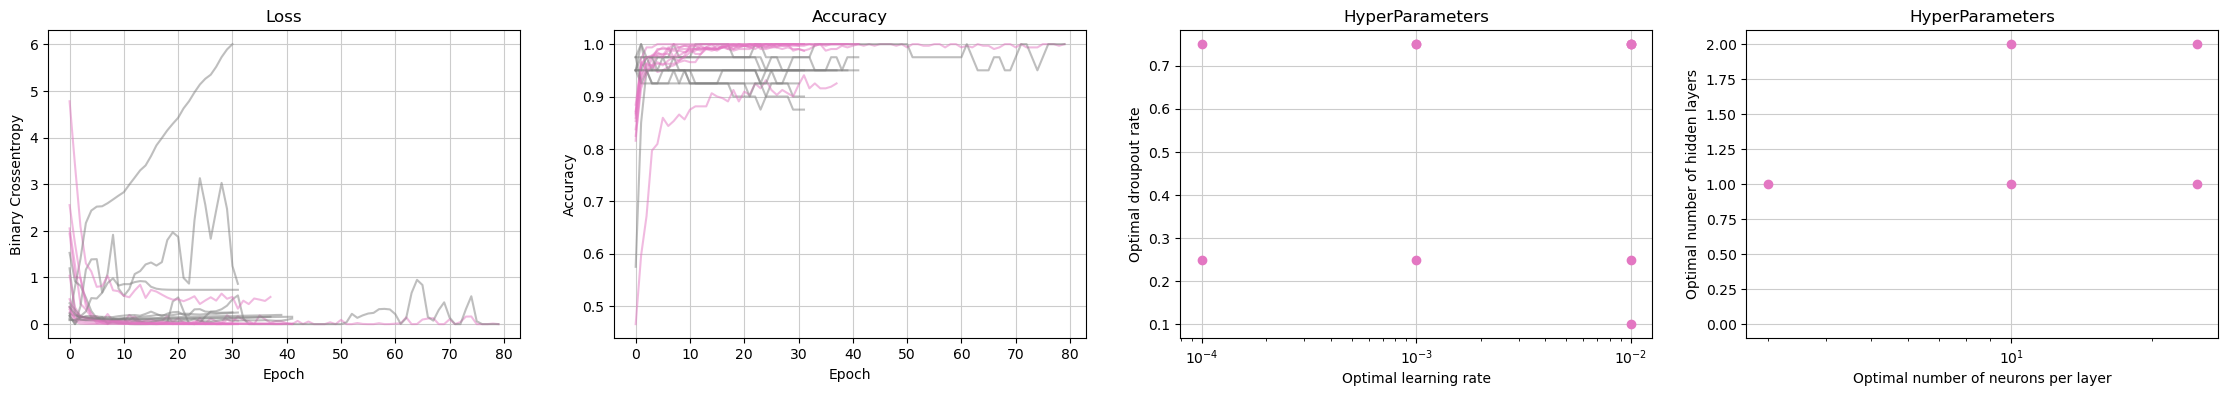

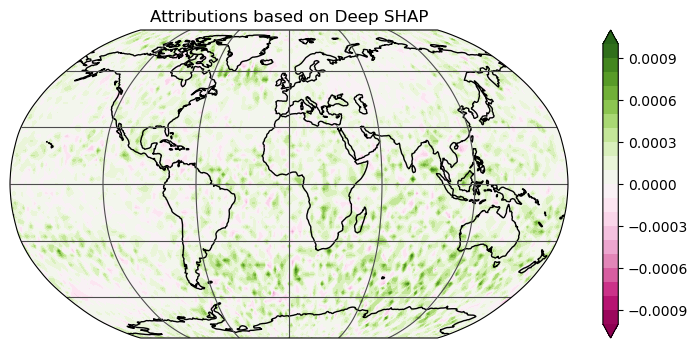

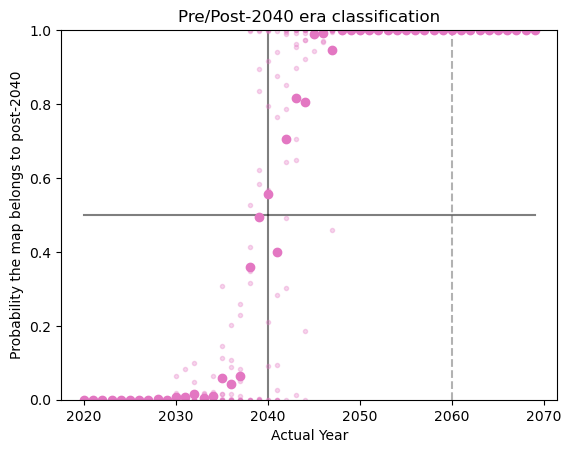

The accuracy of the model across all testing samples is 0.948
The st. dev. of the accuracy of the model across all testing samples is 0.025612496949731372


In [35]:
#train SSP annual temp
train_loop(ts_SSP_ann[:,5:,:,:],'ann_mean_ts_SSP')

Restoring model weights from the end of the best epoch: 27.
Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 66.
Epoch 96: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 65.
Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 63.
Epoch 93: early stopping


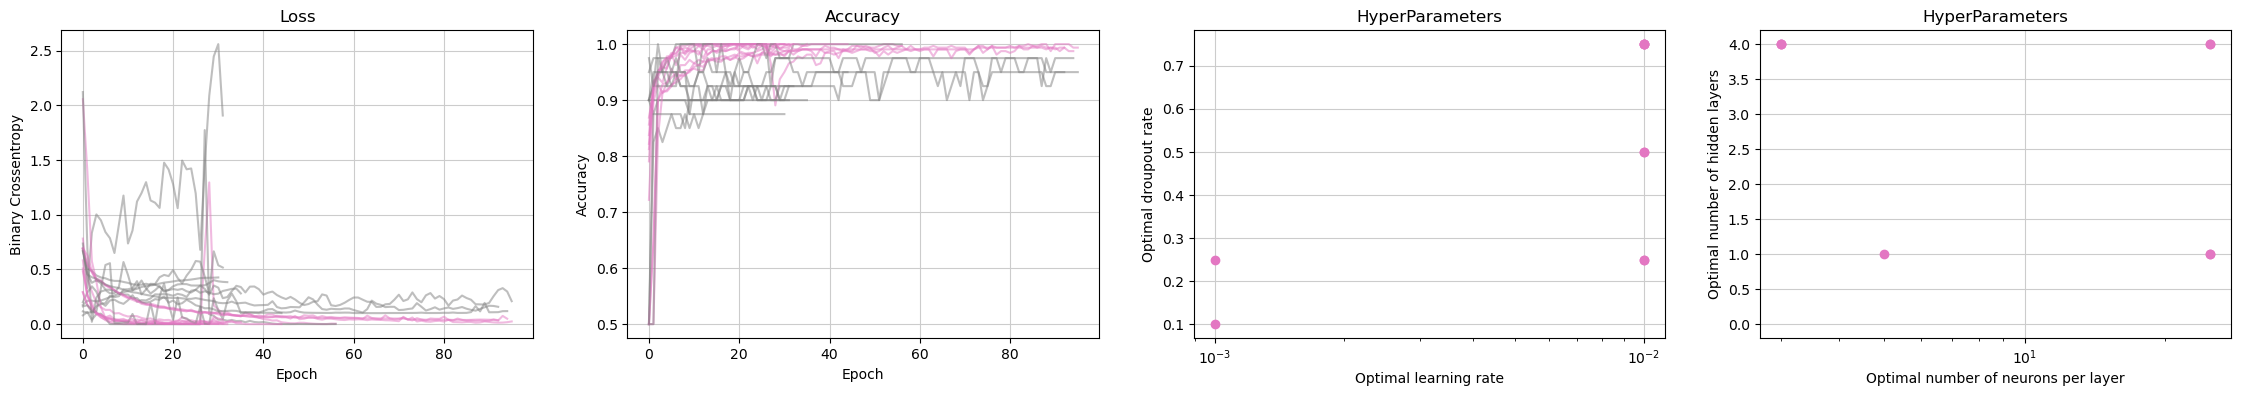

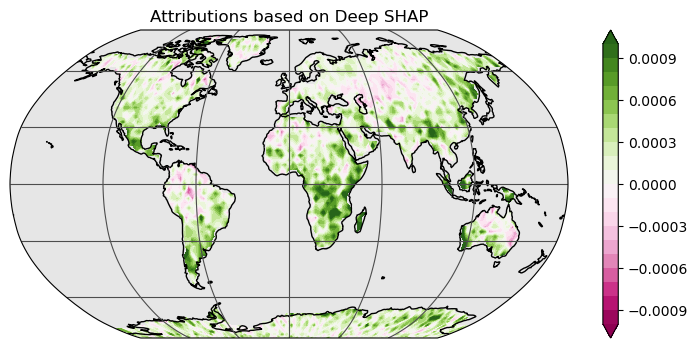

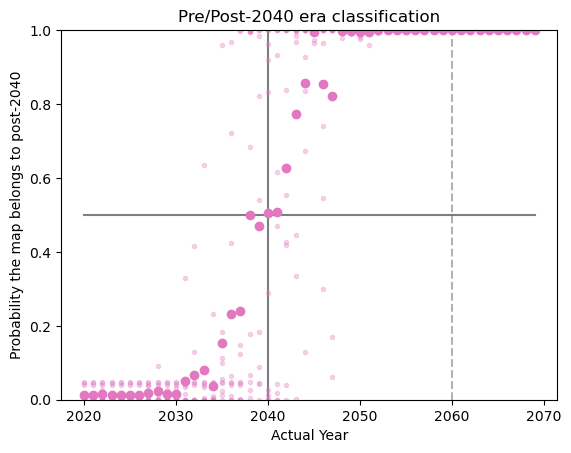

The accuracy of the model across all testing samples is 0.926
The st. dev. of the accuracy of the model across all testing samples is 0.037999999999999985


In [36]:
#train SSP annual temp land
train_loop(ts_land_SSP_ann[:,5:,:,:],'ann_mean_ts_land_SSP')

Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping


Data has no positive values, and therefore cannot be log-scaled.


Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 61.
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 32.
Epoch 62: early stopping


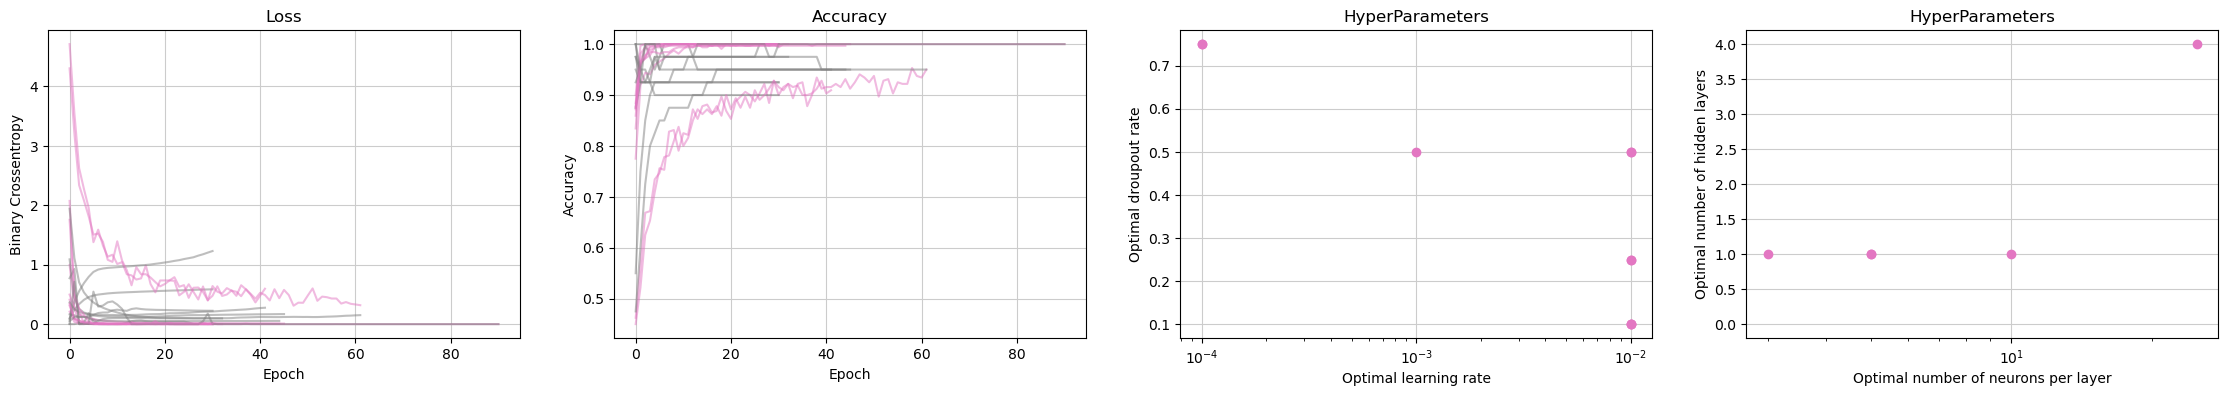

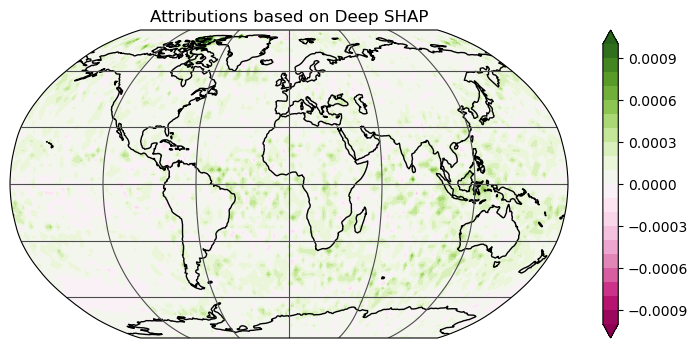

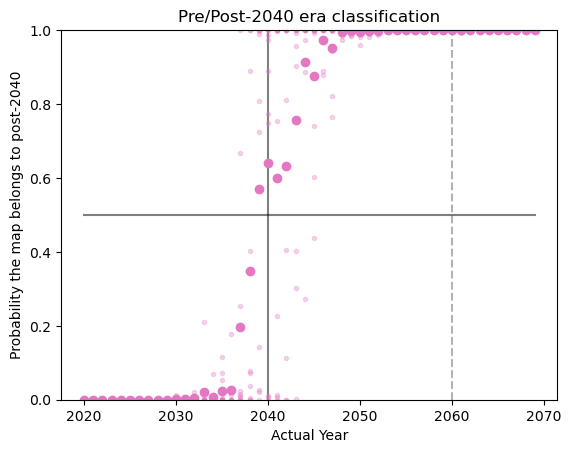

The accuracy of the model across all testing samples is 0.946
The st. dev. of the accuracy of the model across all testing samples is 0.023748684174075822


In [37]:
#train SSP annually-max temp
train_loop(ts_SSP_ann_max[:,5:,:,:],'ann_max_ts_SSP')

Restoring model weights from the end of the best epoch: 167.
Epoch 197: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 20.
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 24.
Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 45: early stopping


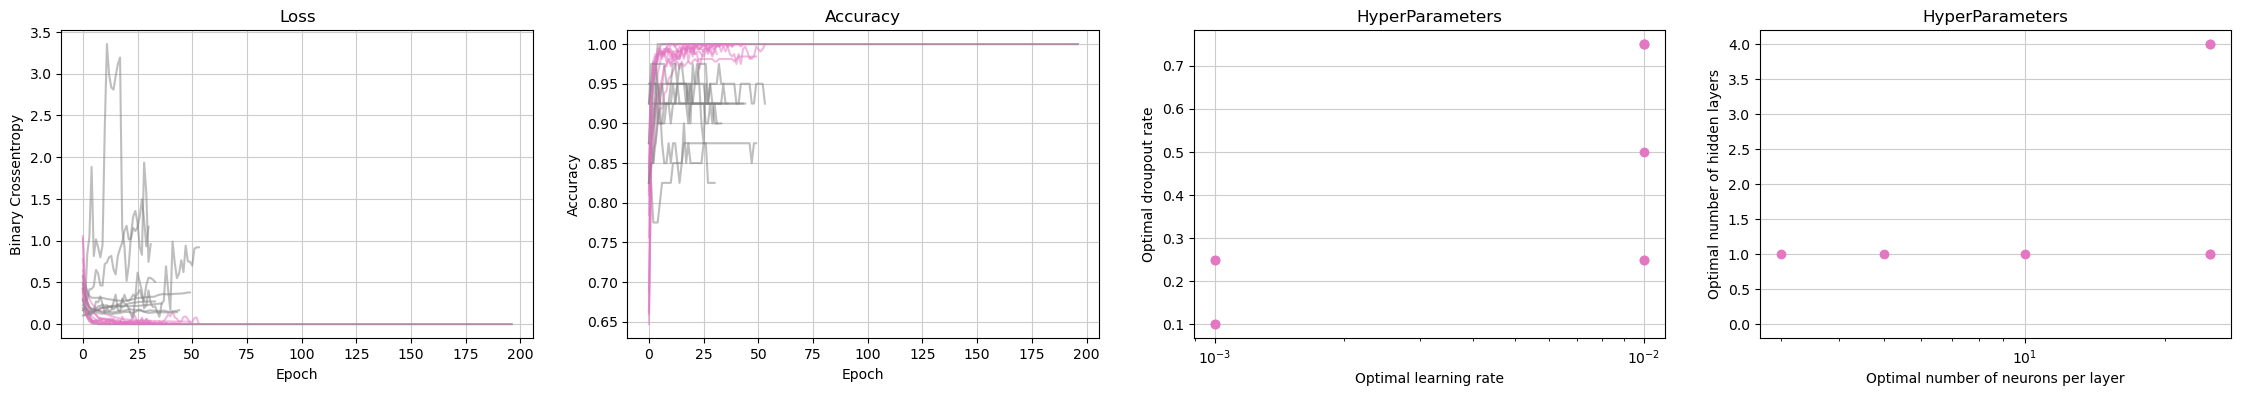

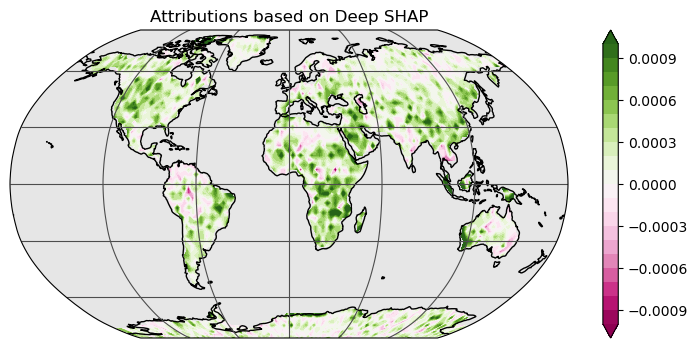

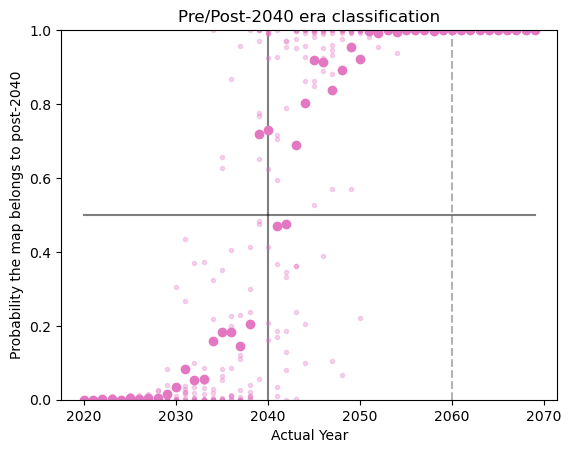

The accuracy of the model across all testing samples is 0.926
The st. dev. of the accuracy of the model across all testing samples is 0.03693237062523876


In [38]:
#train SSP annually-max temp land
train_loop(ts_land_SSP_ann_max[:,5:,:,:],'ann_max_ts_land_SSP')

Restoring model weights from the end of the best epoch: 53.
Epoch 83: early stopping


Data has no positive values, and therefore cannot be log-scaled.


Restoring model weights from the end of the best epoch: 2.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 35.
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 103.
Epoch 133: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 36.
Epoch 66: early stopping


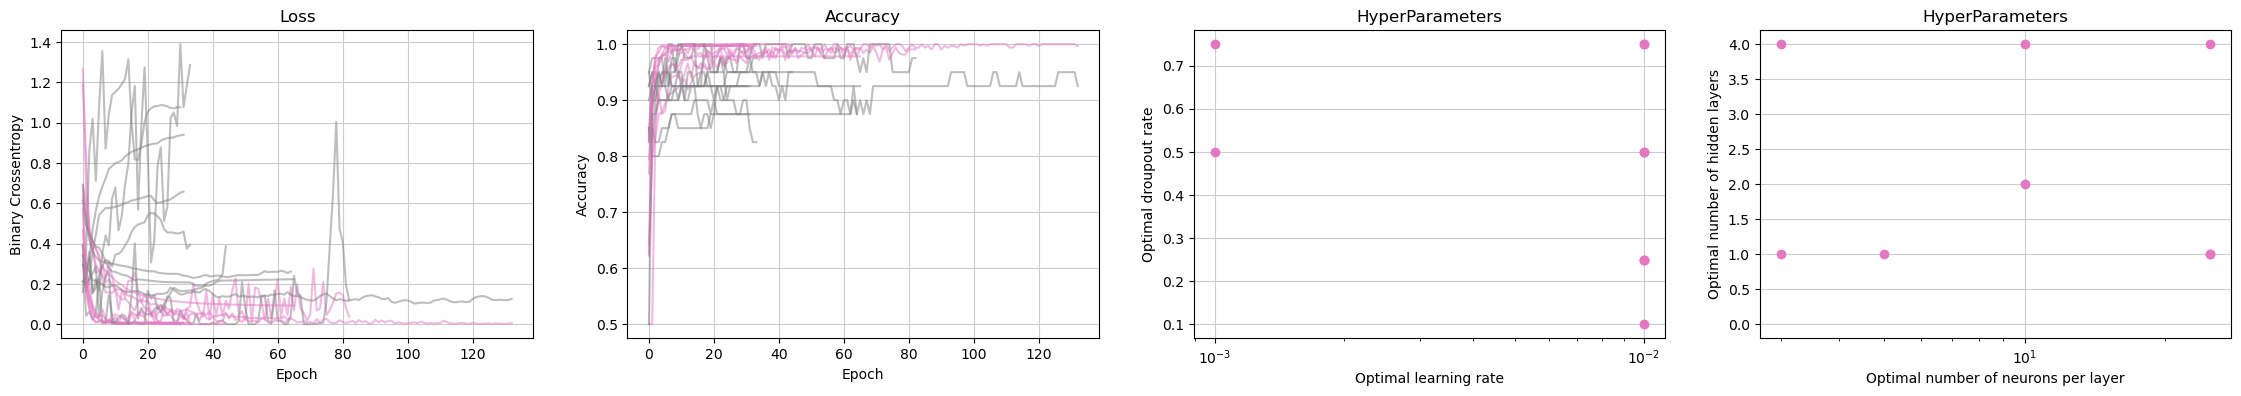

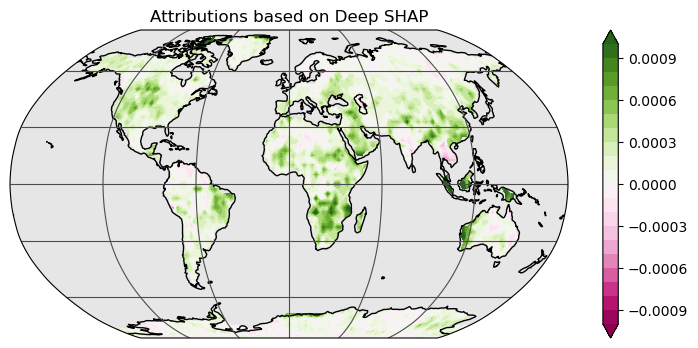

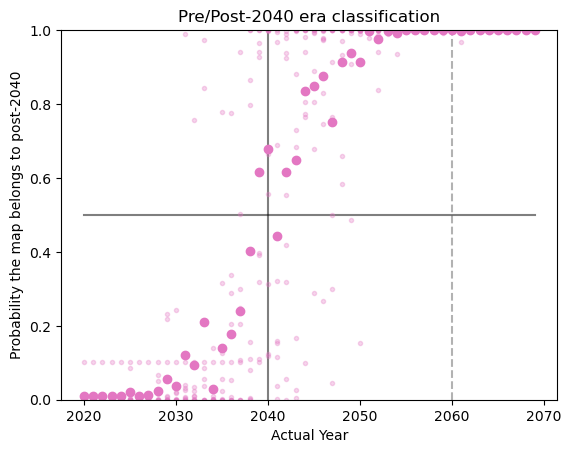

The accuracy of the model across all testing samples is 0.92
The st. dev. of the accuracy of the model across all testing samples is 0.03346640106136301


In [39]:
#train SSP annually-max 5d temp land
train_loop(ts_land_SSP_ann_5dmax[:,5:,:,:],'ann_5dmax_ts_land_SSP')

Restoring model weights from the end of the best epoch: 2.
Epoch 32: early stopping


Data has no positive values, and therefore cannot be log-scaled.


Restoring model weights from the end of the best epoch: 768.
Epoch 798: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 18.
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 38.
Epoch 68: early stopping


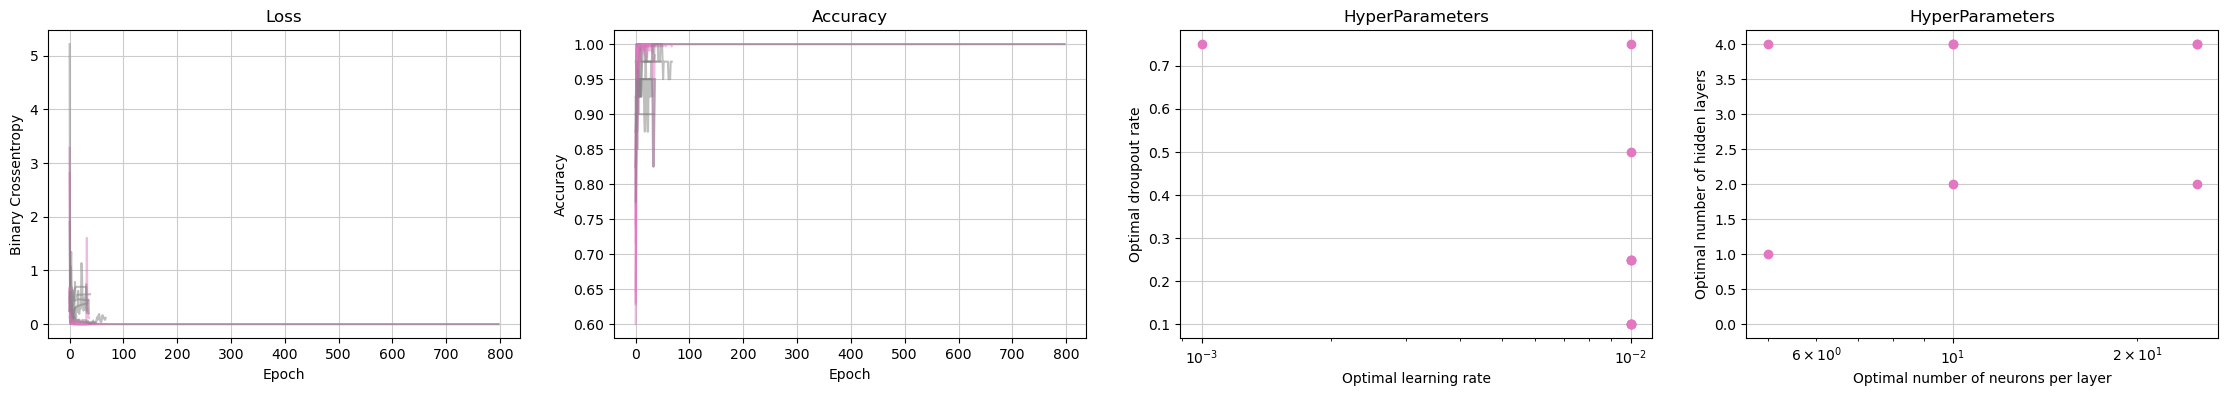

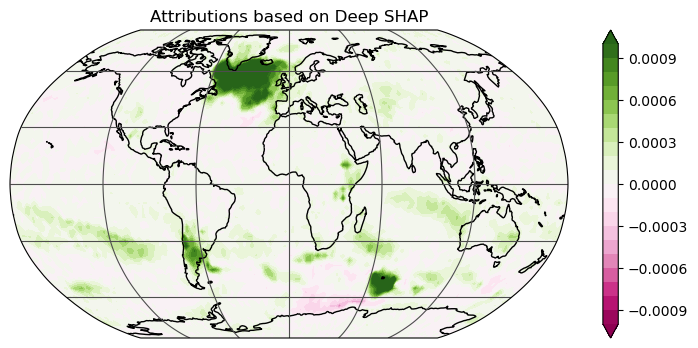

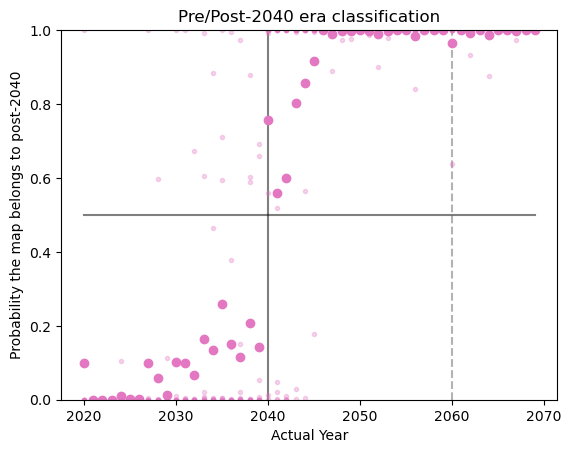

The accuracy of the model across all testing samples is 0.934
The st. dev. of the accuracy of the model across all testing samples is 0.0335261092284804


In [40]:
#train SSP-SAI annual temp
# switching data
ts_SSP_SAI_ann=np.concatenate((ts_SSP_ann[:,5:25,:,:],ts_SAI_ann[:,5:,:,:]),axis=1)
train_loop(ts_SSP_SAI_ann,'ann_mean_ts_SAI')

Restoring model weights from the end of the best epoch: 23.
Epoch 53: early stopping


Data has no positive values, and therefore cannot be log-scaled.


Restoring model weights from the end of the best epoch: 41.
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 23.
Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 46.
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 28.
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 17.
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 45.
Epoch 75: early stopping
Restoring model weights from the end of the best epoch: 17.
Epoch 47: early stopping


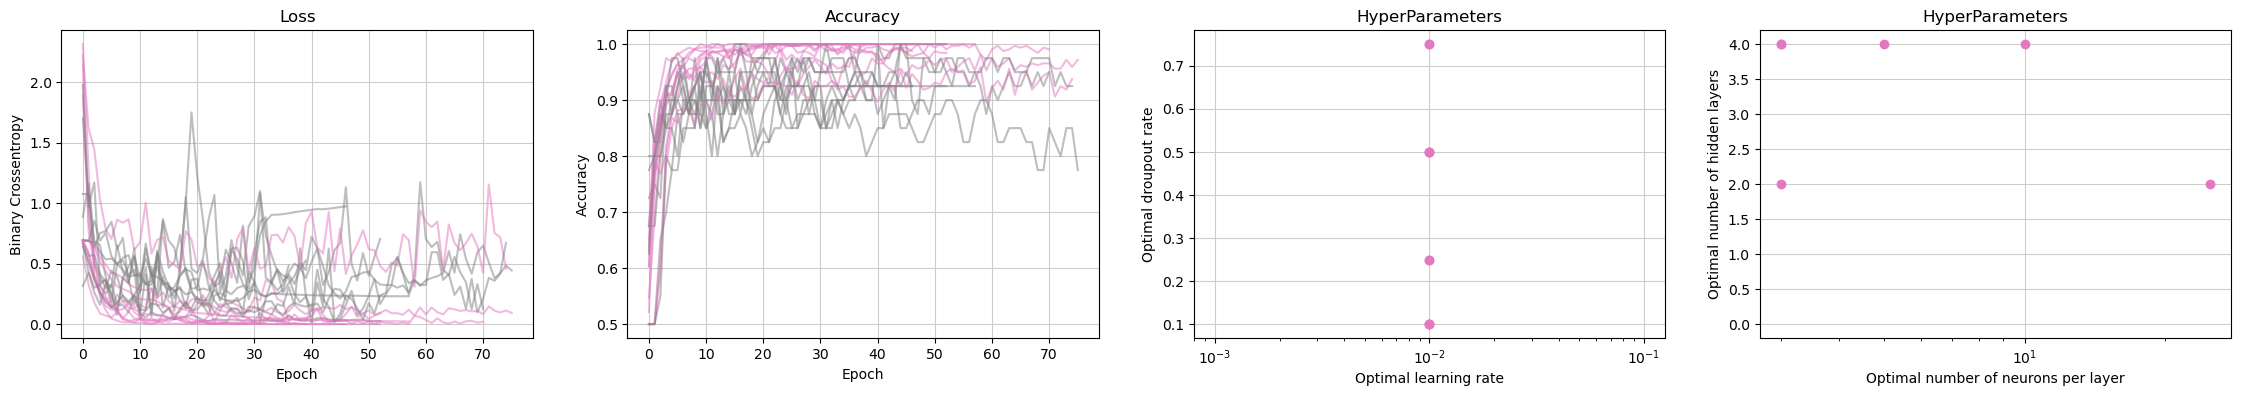

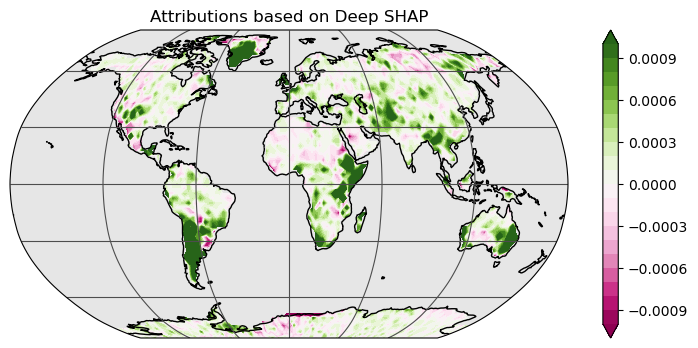

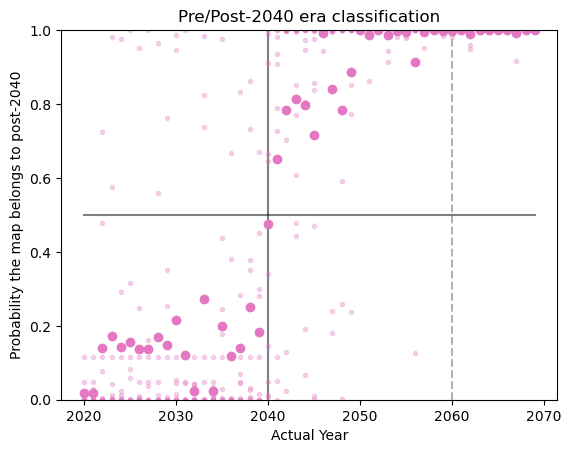

The accuracy of the model across all testing samples is 0.91
The st. dev. of the accuracy of the model across all testing samples is 0.0458257569495584


In [41]:
#train SSP-SAI annual temp land
# switching data
ts_land_SSP_SAI_ann=np.concatenate((ts_land_SSP_ann[:,5:25,:,:],ts_land_SAI_ann[:,5:,:,:]),axis=1)
train_loop(ts_land_SSP_SAI_ann,'ann_mean_ts_land_SAI')

Restoring model weights from the end of the best epoch: 20.
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 127.
Epoch 157: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 36: early stopping


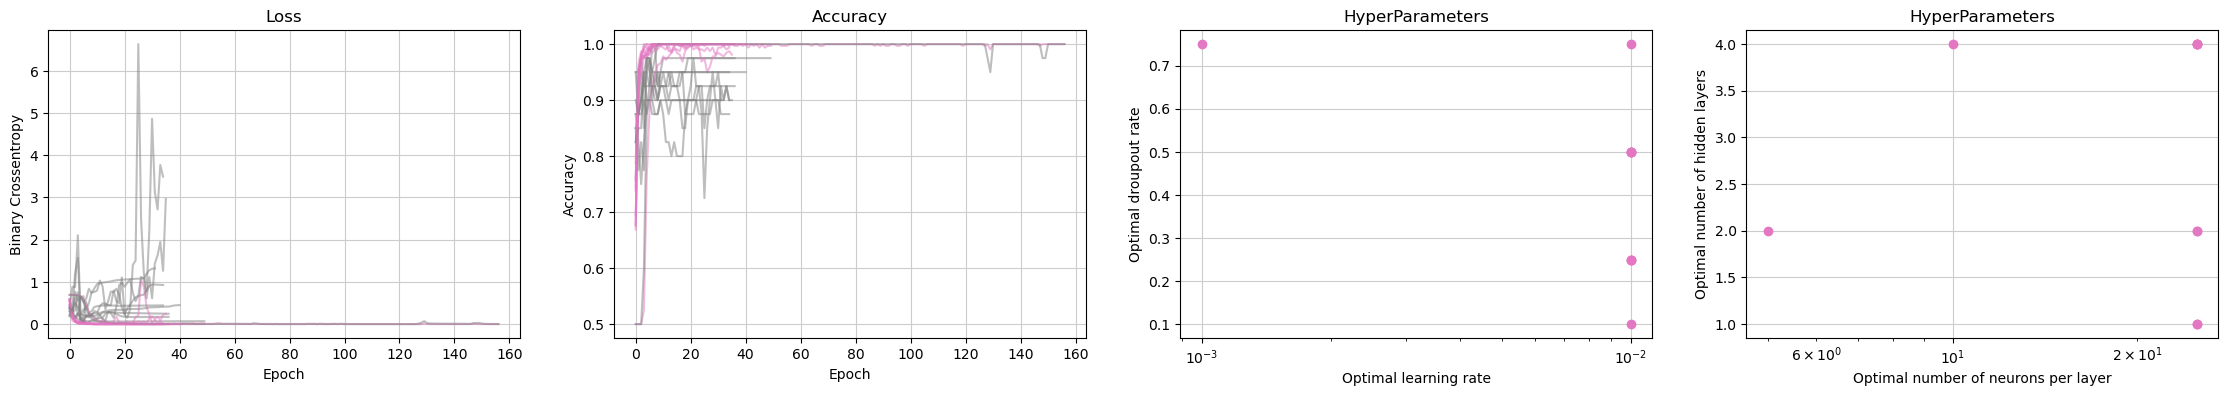

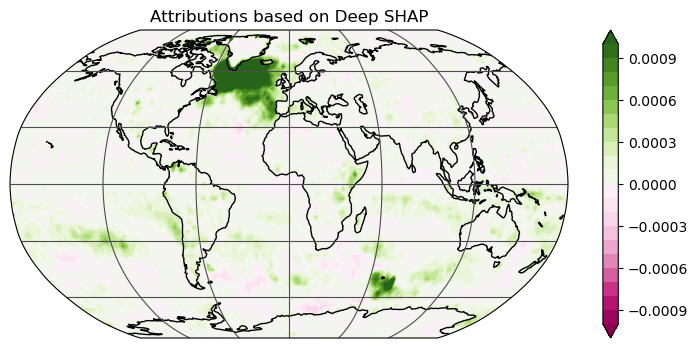

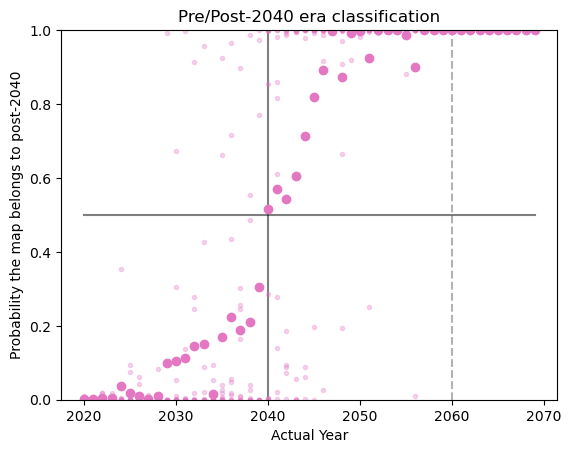

The accuracy of the model across all testing samples is 0.916
The st. dev. of the accuracy of the model across all testing samples is 0.04882622246293478


In [42]:
#train SSP-SAI annually-max temp
# switching data
ts_SSP_SAI_ann_max=np.concatenate((ts_SSP_ann_max[:,5:25,:,:],ts_SAI_ann_max[:,5:,:,:]),axis=1)
train_loop(ts_SSP_SAI_ann_max,'ann_max_ts_SAI')

Restoring model weights from the end of the best epoch: 7.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 24.
Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 40: early stopping


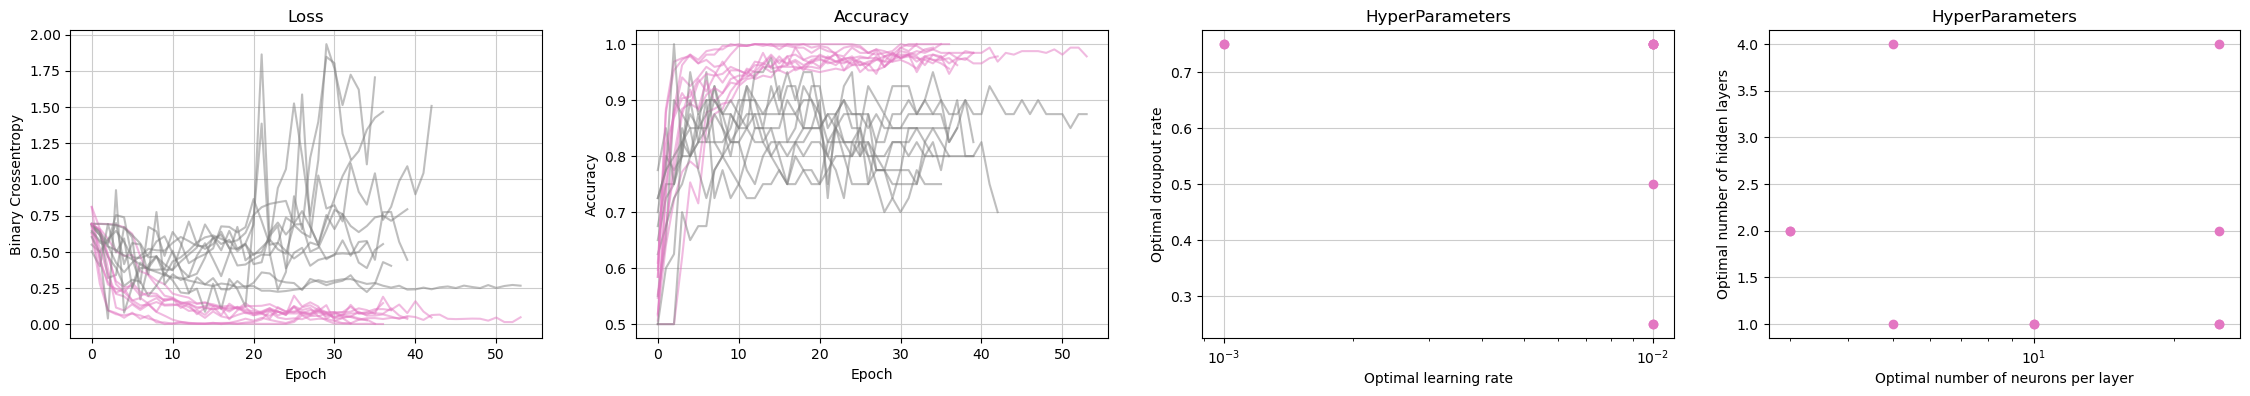

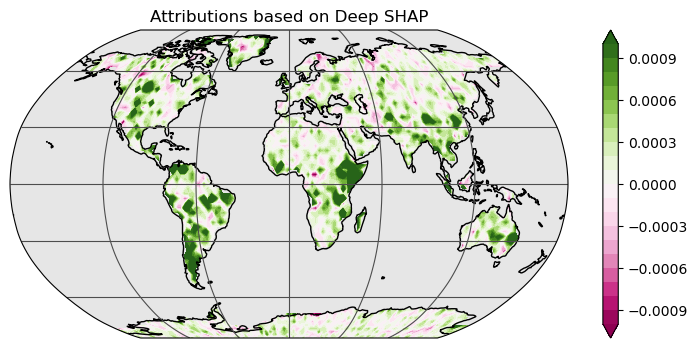

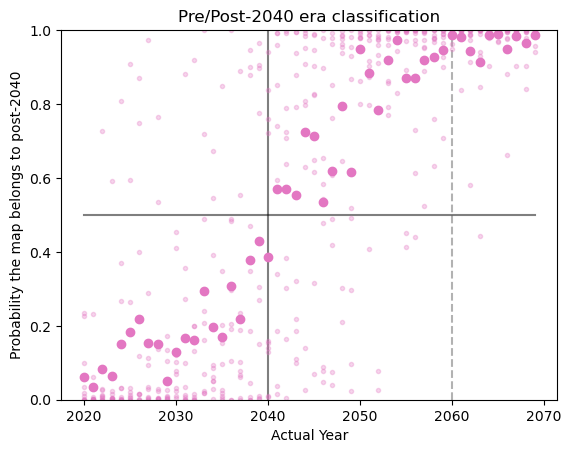

The accuracy of the model across all testing samples is 0.858
The st. dev. of the accuracy of the model across all testing samples is 0.046000000000000006


In [43]:
#train SSP-SAI annually-max temp land
# switching data
ts_land_SSP_SAI_ann_max=np.concatenate((ts_land_SSP_ann_max[:,5:25,:,:],ts_land_SAI_ann_max[:,5:,:,:]),axis=1)
train_loop(ts_land_SSP_SAI_ann_max,'ann_max_ts_land_SAI')

Restoring model weights from the end of the best epoch: 3.
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 60.
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 122.
Epoch 152: early stopping
Restoring model weights from the end of the best epoch: 18.
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 17.
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 28.
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 66.
Epoch 96: early stopping
Restoring model weights from the end of the best epoch: 21.
Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 36: early stopping


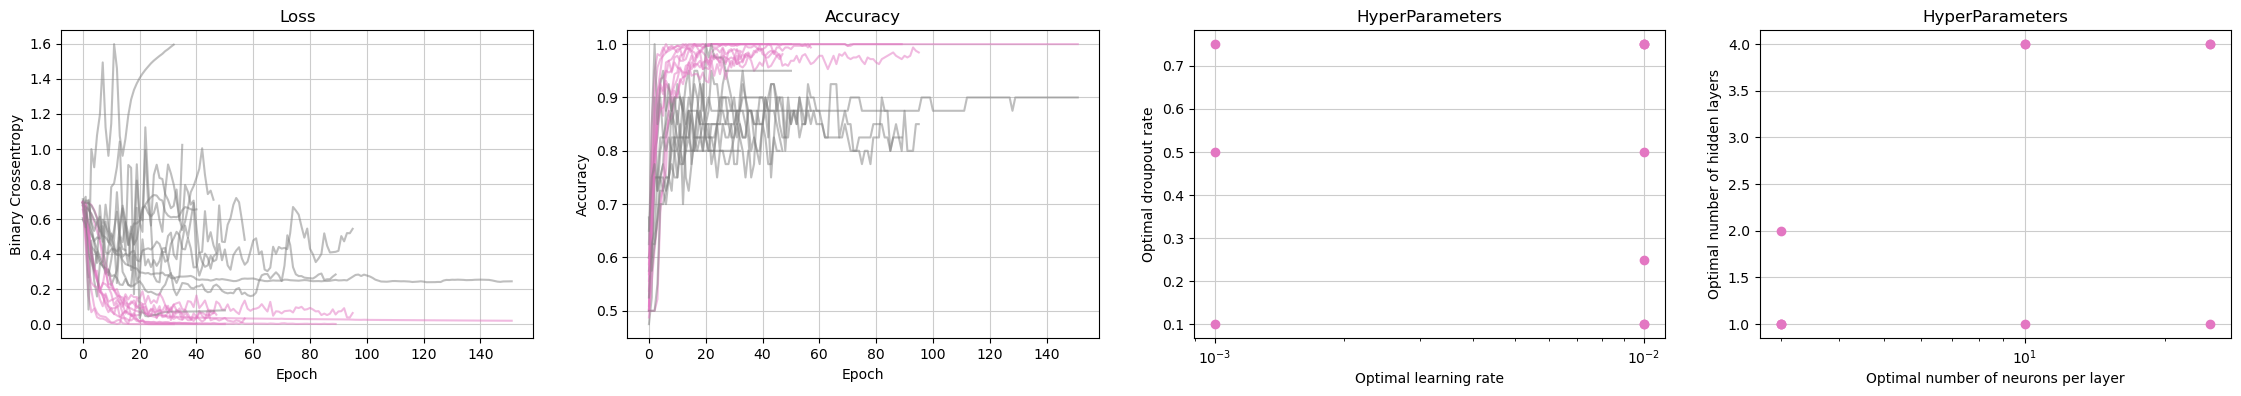

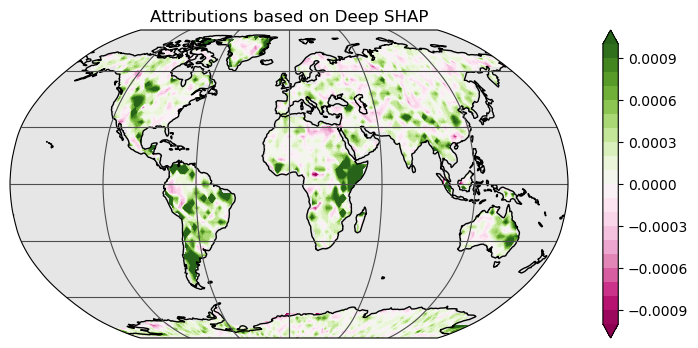

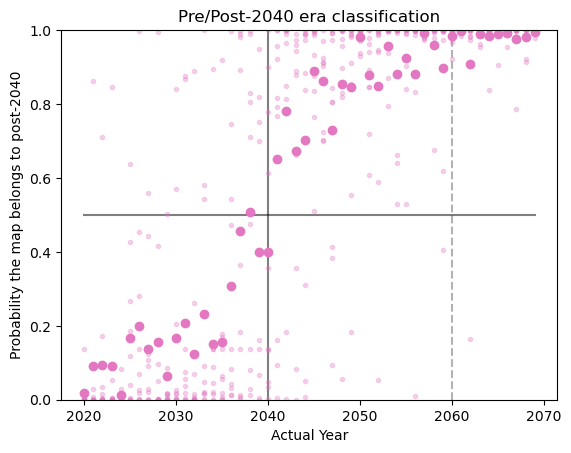

The accuracy of the model across all testing samples is 0.88
The st. dev. of the accuracy of the model across all testing samples is 0.03687817782917156


In [44]:
#train SSP-SAI annually-max 5d temp land
# switching data
ts_land_SSP_SAI_ann_5dmax=np.concatenate((ts_land_SSP_ann_5dmax[:,5:25,:,:],ts_land_SAI_ann_5dmax[:,5:,:,:]),axis=1)
train_loop(ts_land_SSP_SAI_ann_5dmax,'ann_5dmax_ts_land_SAI')